In [88]:
#Notebook written by Miguel de Jesús Martínez Felipe and Divyanshu Singh 
# Quantum Euclidean Distance for Two Images using Quantum Fourier Transform
#https://github.com/Miguelillnino and https://github.com/divshacker

from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_distribution
from numpy import pi
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector, state_fidelity, process_fidelity, DensityMatrix
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit.providers.aer import AerSimulator
from typing import List, Union
from qiskit.circuit import Gate
import math

#Libraries for Image Processing 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
def add_qubit(qc, q, sign = 1):
    if q > 3:
        sign = -sign
        
    for indx, qb in enumerate(range(8,12)):
        qc.cp(sign * pi / (2**(3 - indx)), q, qb)

In [90]:
# For 2 qubits per image
# firstPart = 3
# secondPart = 1
# secondPart = secondPart -2
# firstPart = firstPart - 2

# For 4 qubits per image
# firstPart = 5
# secondPart = 1

def rotationsFourier(qc, sign = 1):
    qc.append(QFT(4), range(8,12))
    qPrima = 0
#   firstPart y secondPart, number of rotations
    firstPart = 5
    secondPart = 1
    for q in range(0,8):
        if q > 3:
            secondPart = secondPart -2
            qPrima = q + secondPart
        else:
            firstPart = firstPart - 2
            qPrima = q + firstPart
#         print(q)
        for index in range(0,2**qPrima):
            add_qubit(qc, q, sign)
            qc.barrier()
   
    qc.append(QFT(4,inverse=True), range(8,12)) #invQFT(4)

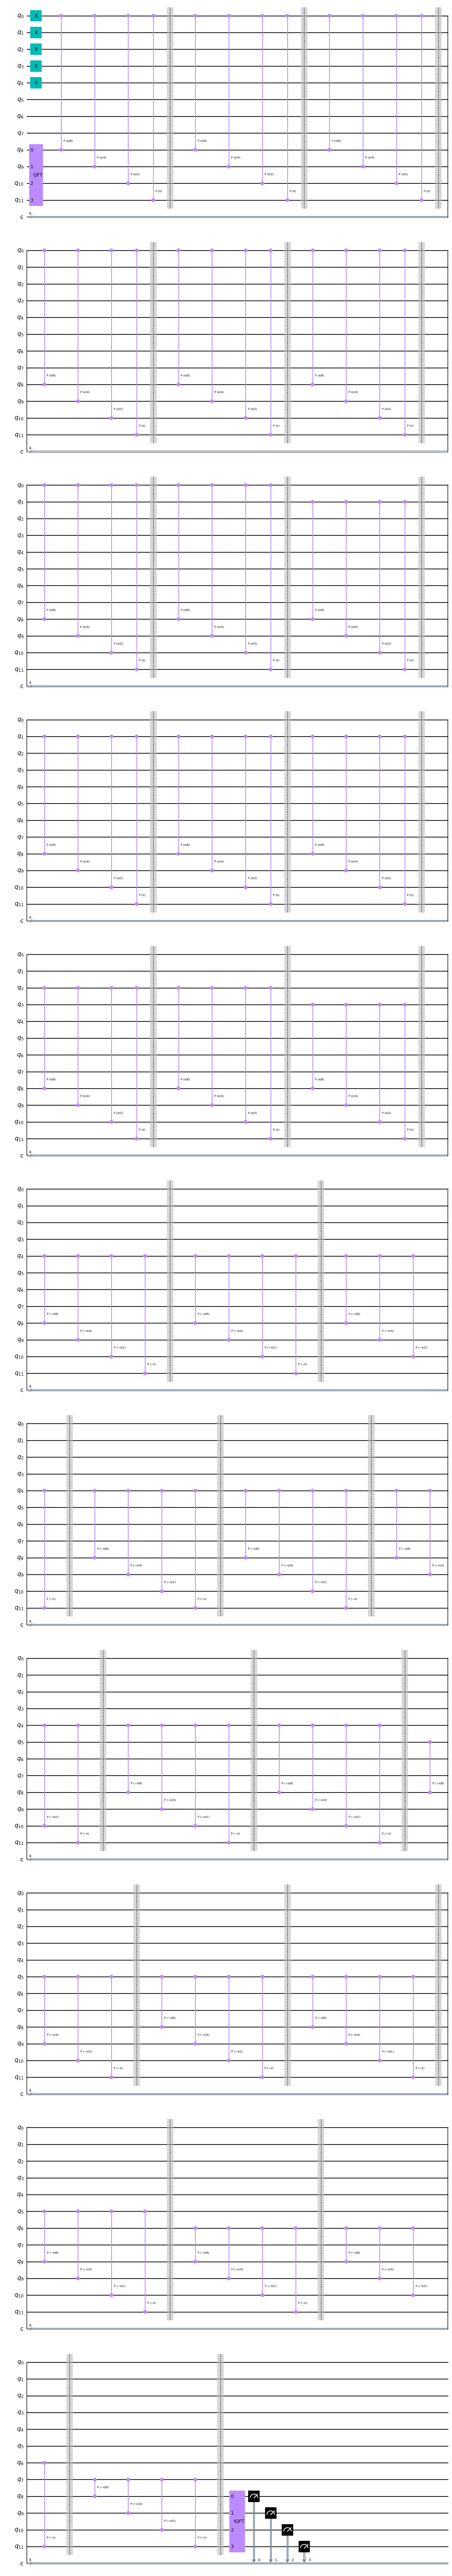

In [91]:
qc = QuantumCircuit(12,4)
# Pixel from the first image
qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
# ------------------------------
# ------------------------------
# ------------------------------
# Pixel from the second image
qc.x(4)

rotationsFourier(qc)

qc.measure(range(8,12), range(4))
#qc = qc.reverse_bits()

qc.draw('mpl')

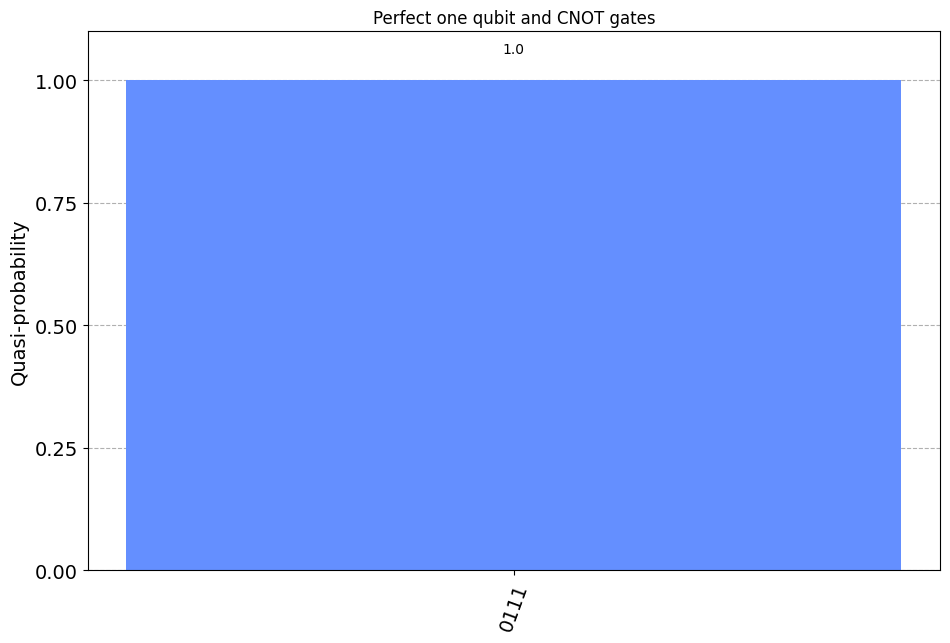

In [92]:

backend = Aer.get_backend('qasm_simulator')
job_sim = backend.run(transpile(qc,backend), shots=1024)

#job = execute(qc, backend, shots = 5)
plot_histogram(job_sim.result().get_counts())

plot_distribution(job_sim.result().get_counts(), title="Perfect one qubit and CNOT gates",
                  figsize=(11, 7))#filename= 'perfect_cnot'

In [93]:
# Error probabilities
prob_1 = 2.670e-4   # 1-qubit gate
prob_2 = 8.536e-3 # 2-qubit gate

# Depolarizing quantum errors
error_1 = depolarizing_error(prob_1, 1)
error_2 = depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['id', 'rz', 'sx', 'x',])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
print(noise_model)


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['rz', 'x', 'sx', 'cx', 'id']
  All-qubits errors: ['id', 'rz', 'sx', 'x', 'cx']


In [94]:
# Get basis gates from noise model
basis_gates = noise_model.basis_gates

In [95]:
# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model,
                       basis_gates=basis_gates)
transpiled_circuit = transpile(qc, backend)
result = backend.run(transpiled_circuit, shots=1024).result()

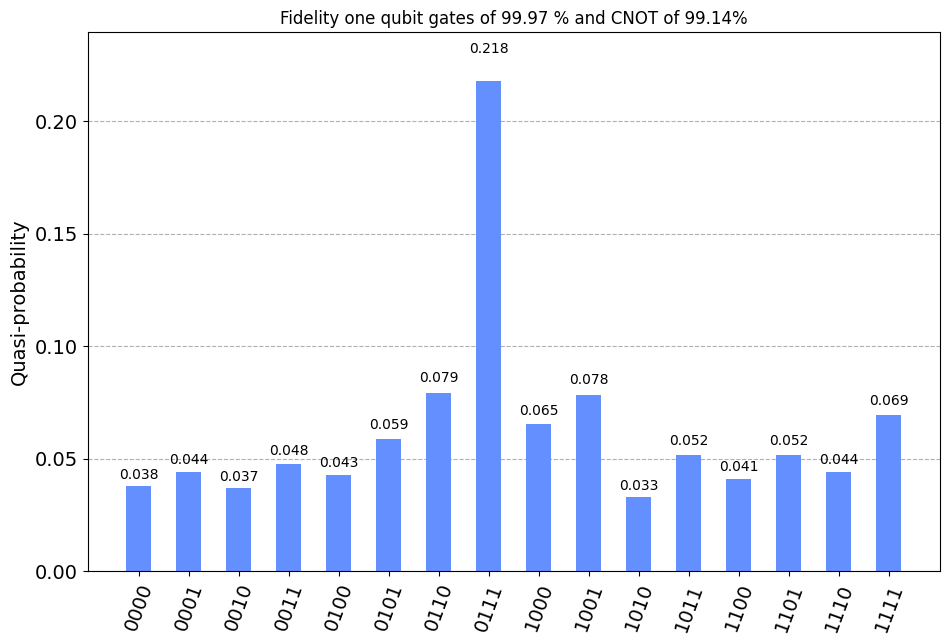

In [96]:
plot_distribution(result.get_counts(), title="Fidelity one qubit gates of 99.97 % and CNOT of 99.14%",
                  figsize=(11, 7)) #,filename= '99_cnot'

In [97]:
result.get_counts().get("0111")/1024

0.2177734375

In [98]:
1-0.01

0.99

In [99]:
noise_values = [0.001, 0.0015, 0.002, 0.005, 0.01]

In [100]:
probs = []
for noise_cnot in noise_values:
    # Error probabilities
    #prob_1 = 2.670e-4   # 1-qubit gate
    #prob_2 = noise_cnot # 2-qubit gate 
    #print(noise_cnot)
    # Depolarizing quantum errors
    #error_1 = depolarizing_error(prob_1, 1)
    error_2 = depolarizing_error(noise_cnot, 2)
    
    # Add errors to noise model
    noise_model = NoiseModel()
    #noise_model.add_all_qubit_quantum_error(error_1, ['id', 'rz', 'sx', 'x',])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    #print(noise_model)
    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    
    # Perform a noise simulation
    backend = AerSimulator(noise_model=noise_model,
                       basis_gates=basis_gates)
    transpiled_circuit = transpile(qc, backend)
    result = backend.run(transpiled_circuit, shots=1024).result()
    probs.append(result.get_counts().get("0111")/1024)

In [101]:
probs

[0.8125, 0.75390625, 0.6904296875, 0.3994140625, 0.189453125]

In [102]:
import numpy as np

In [103]:
1- np.array(noise_values)

array([0.999 , 0.9985, 0.998 , 0.995 , 0.99  ])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


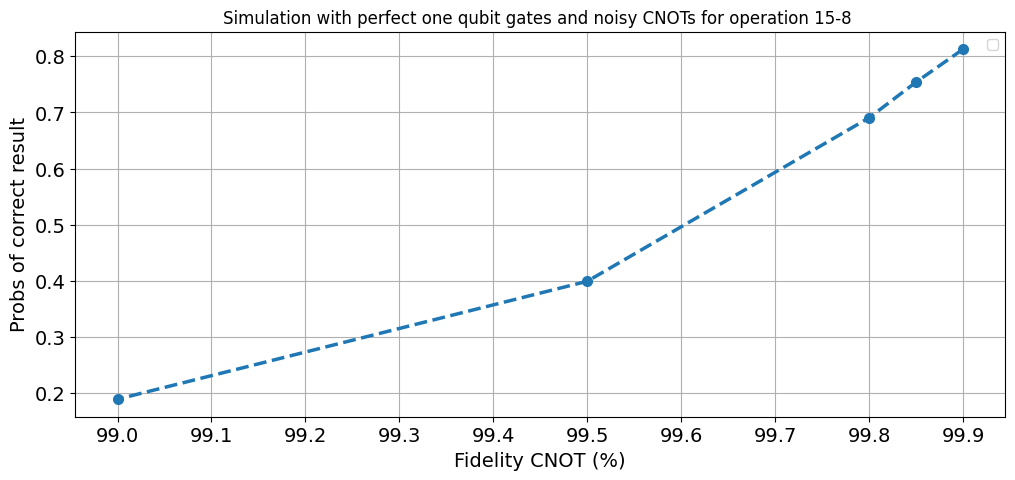

In [104]:
plt.figure(figsize=(12, 5))
plt.plot((1- np.array(noise_values))*100, probs, "o--", linewidth=2.5, markersize=7)
#plt.plot(0,y_3, "o", markersize=7, label = "ZNE Poly order 3")
#plt.plot(0,y_2, "o", markersize=7, label = "ZNE Poly order 2")
#plt.plot(0,y_1, "o", markersize=7, label = "ZNE Linear")
#plt.xticks(size=12)
plt.yticks(size=14)
plt.xticks(np.arange(99,99.999, step=0.1),size=14)
plt.title(r"Simulation with perfect one qubit gates and noisy CNOTs for operation 15-8 ")
plt.xlabel('Fidelity CNOT (%)', size= 14)
plt.ylabel('Probs of correct result', size=14)
plt.legend()
plt.grid()
plt.show()
#plt.savefig("noisy_cnots")